In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]
threshold = (300, 2000)

In [4]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [4]:
# def load_subject(subject, volumes, merged_controls=False):
#     if merged_controls:        
#         if subject[0]=='F':
#             df_mouse = pd.read_csv(data_directory + subject + '/cells300.csv')
#         else:
#             df_mouse = pd.read_csv(data_directory + subject + '/cells_2000.csv')
#         df_mouse = ace.reformat_df_mouse(df=df_mouse)
#         return df_mouse
#     else:
#         if subject[0]=='F':
#             df_mouse = pd.read_csv(data_directory + subject + '/cells300.csv')
#             df_mouse = ace.reformat_df_mouse(df=df_mouse)
#             return df_mouse
        

In [6]:
def load_subject(subject, data_directory, threshold1, threshold2, merged_controls=False):
    file_suffix = 'cells' + str(threshold1) if subject[0] == 'F' else 'cells' + str(threshold2)
    if merged_controls:
        df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    else:
        df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

# Analysis on C57 : threshold 300

In [8]:
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject, 
                                                                                                data_directory=data_directory, 
                                                                                                threshold1=300, 
                                                                                                threshold2=2000, 
                                                                                                merged_controls=True), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/newvolumes/dict_results_across_mice_c57_mergedcontrols.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_c57_mergedcontrols.npy', 
                                   allow_pickle=True).item()

In [12]:
subjects = list(dict_results_across_mice.keys())

# List areas with null cell count

In [14]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [15]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [16]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['BL17Control',
  'F10Control',
  'BL26Control',
  'F16Control',
  'F11Control',
  'F1Control',
  'BL23Control',
  'BL44Control',
  'BL41Control',
  'BL29Control',
  'BL20Control',
  'BL32Control'],
 'Unfam': ['F6Unfam', 'F8Unfam', 'F4Unfam', 'F2Unfam', 'F12Unfam', 'F14Unfam'],
 'Fam': ['F7Fam', 'F15Fam', 'F13Fam', 'F5Fam', 'F3Fam', 'F9Fam']}

# Calculate cell count across experimental groups

In [17]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [18]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count])

In [19]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [20]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,7.63965e-07
Cortical amygdalar area,1.97006e-06
Medial preoptic nucleus,2.54517e-06
Medial amygdalar nucleus,1.21029e-05
Tuberal nucleus,1.38366e-05
Main olfactory bulb,5.50123e-05
Posterior amygdalar nucleus,5.77599e-05
Accessory olfactory bulb,5.7934e-05
Piriform-amygdalar area,0.000117098


In [21]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:25].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,1.94323e-08
Cortical amygdalar area,2.79363e-07
Periventricular hypothalamic nucleus posterior part,7.95711e-07
Medial amygdalar nucleus,2.75272e-06
Posterior amygdalar nucleus,8.7013e-06
Posterodorsal preoptic nucleus,1.89807e-05
Tuberal nucleus,2.01533e-05
Medial preoptic nucleus,7.34484e-05
Nucleus of reuniens,0.000113078


In [22]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Supramammillary nucleus,0.0111725
Nucleus of reuniens,0.0141052
Interanteromedial nucleus of the thalamus,0.0147649
Rhomboid nucleus,0.0224609
Preparasubthalamic nucleus,0.0408905
Central medial nucleus of the thalamus,0.0459932
Tuberomammillary nucleus,0.0484734
Intermediodorsal nucleus of the thalamus,0.0509426
Medial mammillary nucleus,0.0527203


## Calculate cross corr across groups per area on cell count

In [23]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)

In [24]:
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)

In [25]:
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

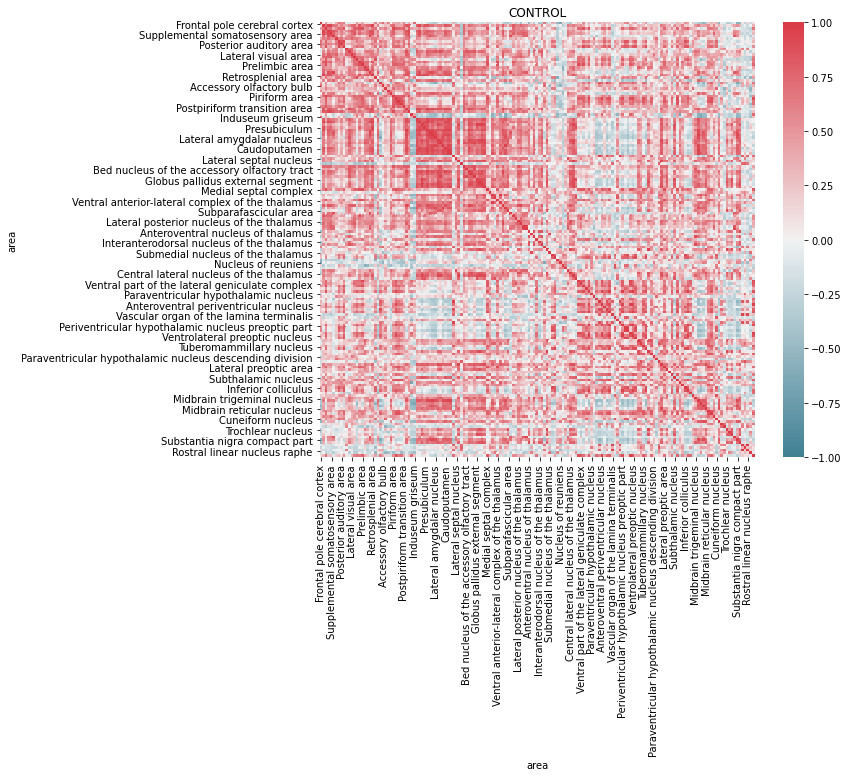

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

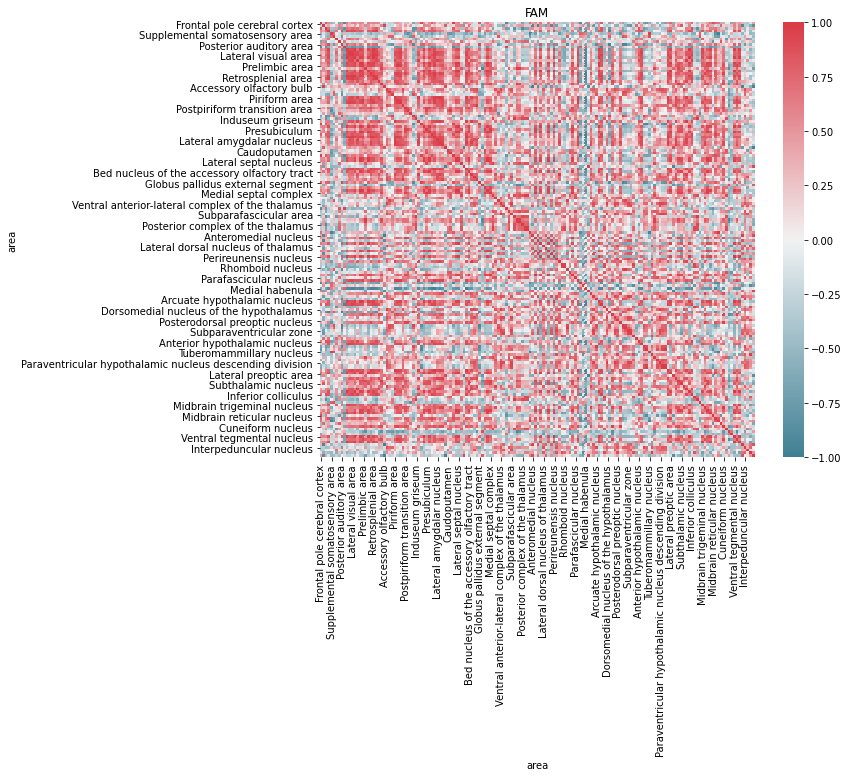

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

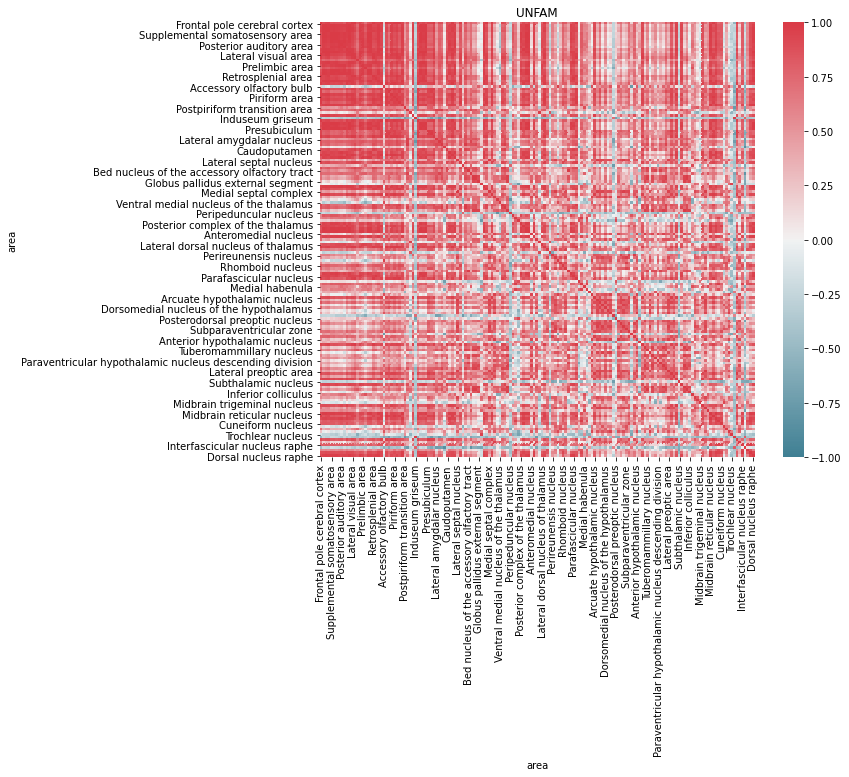

In [28]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [29]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [30]:
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy])

In [31]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [32]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Medial preoptic nucleus,2.55147e-05
Ventral premammillary nucleus,3.45341e-05
Accessory olfactory bulb,0.000521416
Periventricular hypothalamic nucleus posterior part,0.00285922
Fasciola cinerea,0.00407325
Lateral mammillary nucleus,0.00640871
Primary auditory area,0.00996204
Posterodorsal preoptic nucleus,0.01141
Zona incerta,0.011599


In [33]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,1.8089e-05
Periventricular hypothalamic nucleus posterior part,3.56885e-05
Posterodorsal preoptic nucleus,0.000131925
Medial preoptic nucleus,0.000189111
Accessory olfactory bulb,0.00114077
Suprachiasmatic nucleus,0.00217042
Arcuate hypothalamic nucleus,0.00291371
Tuberal nucleus,0.00307459
Lateral mammillary nucleus,0.00526024


In [34]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Nucleus of reuniens,0.00638682
Interanteromedial nucleus of the thalamus,0.0149844
Rhomboid nucleus,0.0156869
Supramammillary nucleus,0.0192732
Central medial nucleus of the thalamus,0.0410569
Suprachiasmatic nucleus,0.0479815
Medial mammillary nucleus,0.0482458
Intermediodorsal nucleus of the thalamus,0.0576893
Preparasubthalamic nucleus,0.0613524


In [35]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)

In [36]:
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)

In [37]:
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

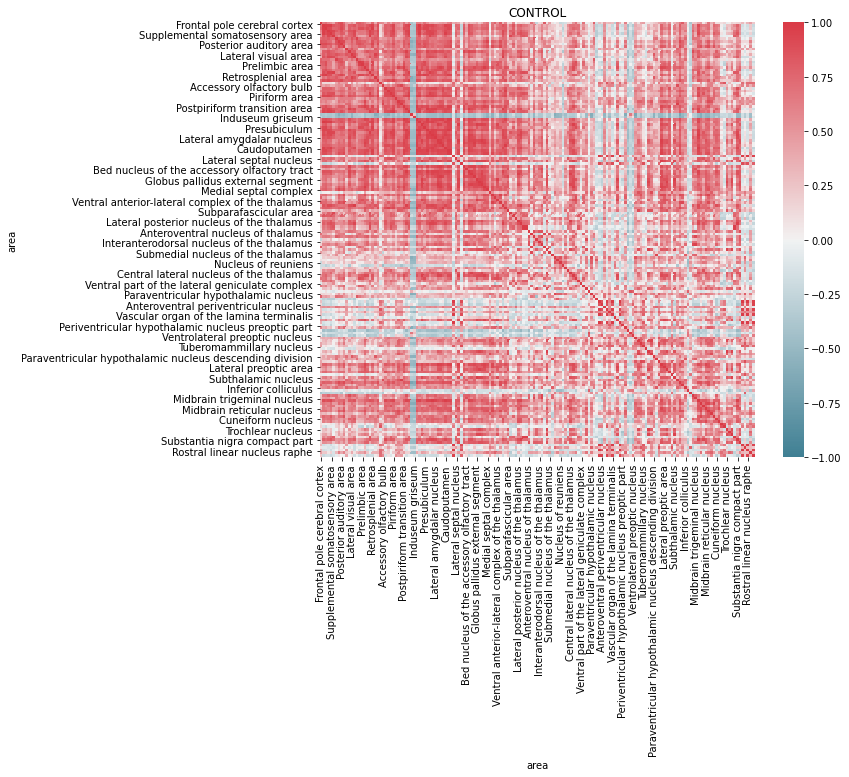

In [38]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

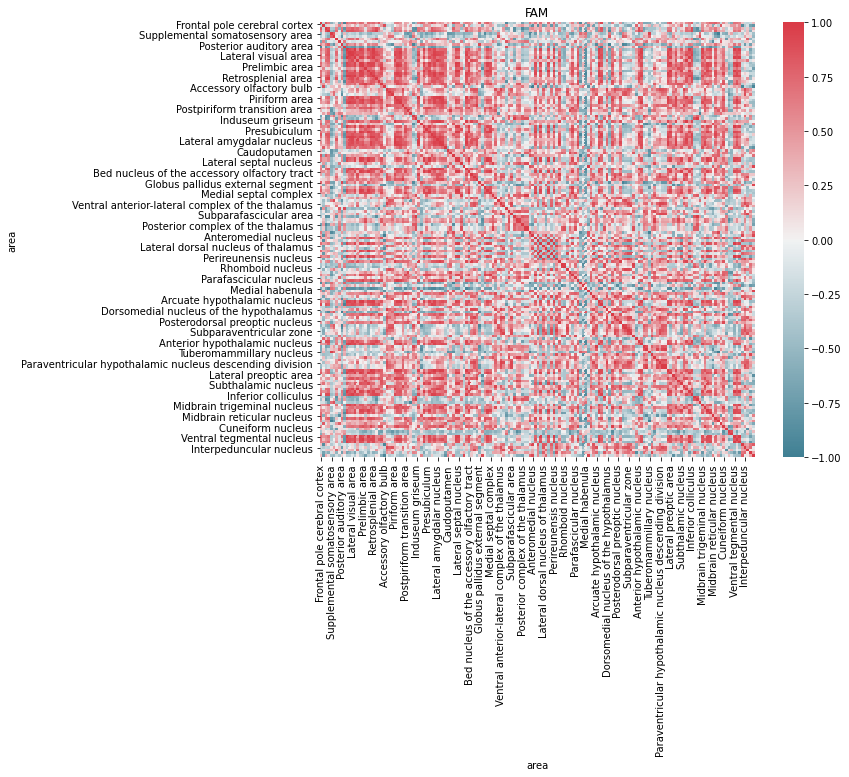

In [39]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

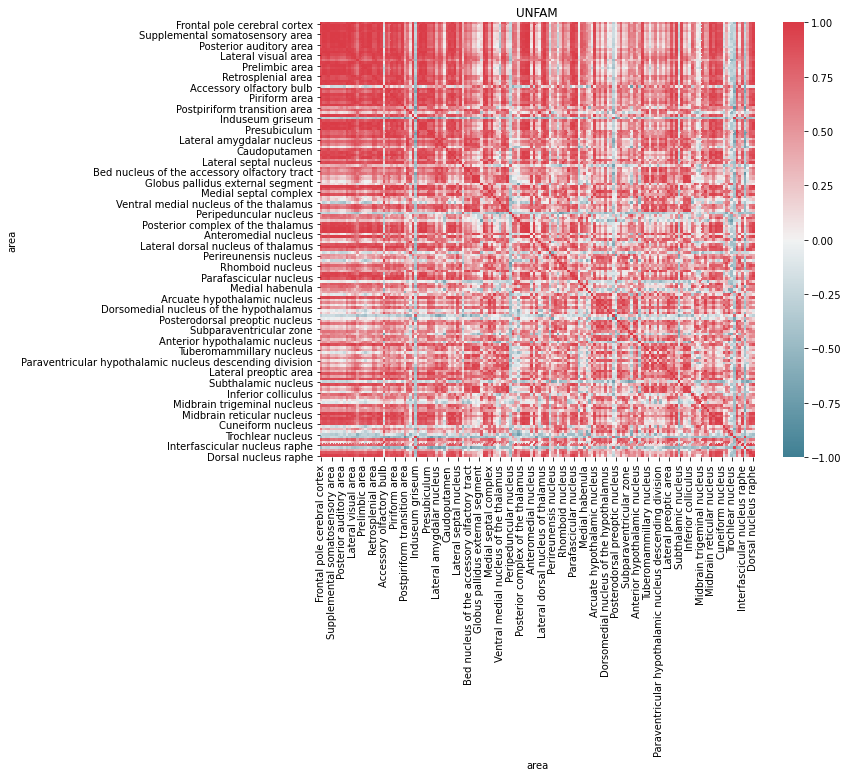

In [40]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')